# **☁️ Contrails Detection Project ☁️**

Hello! Virra's Here, This project is purposed for my PI task. fingers crossed!

# 1️⃣ Library

In [1]:
import numpy as np
import torch
import torch.nn as nn
import os
from torchvision.transforms import Compose,ToTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
from pathlib import Path

!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

from torchvision import models
try:
    from torchsummary import summary
except:
    !pip install torchsummary > /dev/null
    from torchsummary import summary
    
import torch.nn.functional as F
from torchvision import models

ModuleNotFoundError: No module named 'torchvision'

# 2️⃣ Config and Devices

In [ ]:
CONFIG = dict(
    seed=42,
    DATA_ROOT = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/',
    BATCH_SIZE = 16,
    IMG_SIZE = (256,256),
    NUM_TRAIN_SAMPLES = 1000,
    NUM_VAL_SAMPLES = 300,
    NUM_TEST_SAMPLES = 2)

Code above uses a dictionary to store some configuration parameters. The competition is about identifying contrails from satellite images and reducing global warming. The code works as follows:

- The first line creates a dictionary named `CONFIG` and assigns it some key-value pairs using the `dict()` function.
- The second line sets the key `seed` to the value `42`, which is a common random seed used for reproducibility of results.
- The third line sets the key `DATA_ROOT` to the value `'/kaggle/input/google-research-identify-contrails-reduce-global-warming/'`, which is the path to the folder where the data files for the competition are stored.
- The fourth line sets the key `BATCH_SIZE` to the value `16`, which is the number of samples that will be processed in each iteration of the training loop.
- The fifth line sets the key `IMG_SIZE` to the value `(256,256)`, which is a tuple representing the height and width of the images that will be resized and fed to the model.
- The sixth line sets the key `NUM_TRAIN_SAMPLES` to the value `1000`, which is the number of samples that will be used for training the model.
- The seventh line sets the key `NUM_VAL_SAMPLES` to the value `300`, which is the number of samples that will be used for validating the model.
- The eighth line sets the key `NUM_TEST_SAMPLES` to the value `2`, which is the number of samples that will be used for testing the model.

In [ ]:
pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

Code above uses to check if CUDA is available on the system and assign a device accordingly. CUDA is a parallel computing platform and programming model developed by NVIDIA for general computing on graphical processing units (GPUs)¹. PyTorch is an open source machine learning framework that accelerates the path from research prototyping to production deployment².

The code works as follows:

- The first line calls the function `torch.cuda.is_available()` which returns a boolean value indicating if CUDA is currently available³. This function checks if the system has a CUDA-capable GPU and a CUDA driver that can access it.
- The second line uses an if-else statement to assign a device object based on the result of the previous function. If CUDA is available, the device object will be set to `'cuda'`, which means PyTorch will use the GPU for computation. Otherwise, the device object will be set to `'cpu'`, which means PyTorch will use the CPU for computation.
- The third line prints the device object to the console, which will show either `'cuda'` or `'cpu'` depending on the availability of CUDA.

# 2️⃣1️⃣ Exploring Optimal Band

In [4]:
# Define data directory
data_dir = CONFIG['DATA_ROOT']

# List files in the 'train' and 'validation' directories
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'validation')

train_rs = os.listdir(train_dir)
valid_rs = os.listdir(valid_dir)

# Create DataFrames for train and validation data
train_df = pd.DataFrame({'record_id': train_rs, 'train': 'train'})
valid_df = pd.DataFrame({'record_id': valid_rs, 'train': 'valid'})

In [5]:
def plot_correlation_matrix(correlation_matrix, band_labels, band_labels_nickname):
    plt.figure(figsize=(10,10)) # Set the figure size
    sns.set(font_scale=1.2)  # Set font size
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.set(font_scale=0.7)
    sns.heatmap(correlation_matrix, annot=True, fmt=".3f", mask=mask, cmap=cmap, 
                cbar_kws={"shrink": .5}, xticklabels=band_labels, yticklabels=band_labels_nickname)
    plt.xlabel('Band')  # Adding label to x-axis
    plt.ylabel('Band Nickname')  # Adding label to y-axis
    plt.title('Correlation matrix of Band Data')
    plt.show()

Function `plot_correlation_matrix` used to plot a correlation matrix of band data. Here's what it does:

- It takes three parameters: `correlation_matrix`, `band_labels`, and `band_labels_nickname`.
- It sets the figure size to 10x10 and the font size to 1.2.
- It creates a mask for the upper triangle of the correlation matrix.
- It generates a custom diverging color map.
- It draws a heatmap of the correlation matrix with the mask and correct aspect ratio. The heatmap is annotated with the correlation coefficients, formatted to three decimal places.
- It labels the x-axis as 'Band', the y-axis as 'Band Nickname', and gives the plot a title 'Correlation matrix of Band Data'.
- Finally, it displays the plot using `plt.show()`. 

This function is useful for visualizing how different bands are correlated with each other. The heatmap makes it easy to identify highly correlated bands. The color coding helps in quickly spotting patterns in the data.

In [6]:
def normalize_range(data, bounds):
    return (data - bounds[0]) / (bounds[1] - bounds[0])

Function `normalize_range` used to normalize data to a specific range. Here's what it does:

- It takes two parameters: `data` and `bounds`.
- `data` is the input data that you want to normalize.
- `bounds` is a tuple or list containing two elements, representing the lower and upper bounds of the range, respectively.
- The function subtracts the lower bound (`bounds[0]`) from each element in `data`, and then divides by the range (`bounds[1] - bounds[0]`).
- The result is that all elements in `data` are scaled to fall within the range 0 to 1, relative to the original bounds.

This function is useful for preprocessing data before using it in machine learning algorithms, as many algorithms perform better when their input data is normalized. It's also useful for transforming data so it can be visualized on a consistent scale.

In [7]:
def correlation_create_ash(record_id, directory):
    _T11_BOUNDS = (243, 303)                   #
    _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
    _TDIFF_BOUNDS = (-4, 2)

    record_data = {}
    for band in range(8, 17):  # For bands 8 through 16
        band_key = f"band_{band:02d}"
        band_data = np.load(os.path.join(directory, record_id, band_key + ".npy"))
        record_data[band_key] = band_data[:,:,4]                                          # Only look at current time

    record_data['r'] = normalize_range(record_data["band_15"] - record_data["band_14"], _TDIFF_BOUNDS)
    record_data['g'] = normalize_range(record_data["band_14"] - record_data["band_11"], _CLOUD_TOP_TDIFF_BOUNDS)
    record_data['b'] = normalize_range(record_data["band_14"], _T11_BOUNDS)
    
    if directory == 'train':
        individual = np.load(os.path.join(directory, record_id, 'human_individual_masks' + ".npy"))
        record_data['mean_mask'] = individual.sum(axis=3) / individual.shape[3]
    else:
        record_data['mask'] = np.load(os.path.join(directory, record_id, 'human_pixel_masks' + ".npy")).squeeze()

    band_values = np.array([band_data.flatten() for band_data in record_data.values()])
    correlation_matrix = np.corrcoef(band_values)
    correlation_matrix = np.nan_to_num(correlation_matrix)

    return correlation_matrix

Function `correlation_create_ash` used to create a correlation matrix for a given record. Here's what it does:

- It takes two parameters: `record_id` and `directory`.
- It initializes an empty dictionary `record_data`.
- For each band from 8 to 16, it loads the corresponding band data from a numpy file and stores the current time slice of the data in `record_data`.
- If the directory is 'train', it calculates the mean mask from the individual masks and stores it in `record_data`. Otherwise, it loads the pixel mask and stores it in `record_data`.
- It flattens each band data and stacks them into a 2D array `band_values`.
- It calculates the correlation matrix of `band_values` using `np.corrcoef` and replaces any NaN values with zero.
- Finally, it returns the correlation matrix.

This function is useful for analyzing how different bands are correlated with each other. The correlation matrix can provide insights into which bands have similar patterns. The mean mask or pixel mask can be used to focus the analysis on areas with human presence. The function assumes that the band data and masks are stored as numpy files in a specific directory structure. The directory and record id are provided as parameters to the function.

In [8]:
for n,i in enumerate(train_rs):
    if n == 0:
        cor = correlation_create_ash(str(i), data_dir+'train')
        total_cor = cor
    elif n%10 == 0:
        cor = correlation_create_ash(str(i), data_dir+'train')
        total_cor += cor
    if n == 10000 - 1:
        break
correlation_matrix = total_cor/1000

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Code above used to calculate the average correlation matrix for a set of records. Here's how it works:

- It initializes a loop over the `train_rs` list, which presumably contains record identifiers.
- For each record, it calls the `correlation_create_ash` function with the record identifier and the directory path to the training data. This function returns a correlation matrix for the given record.
- If it's the first record (when `n == 0`), it stores the correlation matrix in `total_cor`. For subsequent records, it adds the correlation matrix to `total_cor`.
- The loop stops after processing 10,000 records.
- Finally, it calculates the average correlation matrix by dividing `total_cor` by 1,000.

This code is useful for analyzing patterns across multiple records. By averaging the correlation matrices, it can highlight consistent correlations between different bands. Please note that there seems to be a typo in the code: `elif n == 0:` should probably be `else:`. Also, dividing by 1,000 might be a mistake if you're processing 10,000 records; you might want to divide by 10,000 instead.

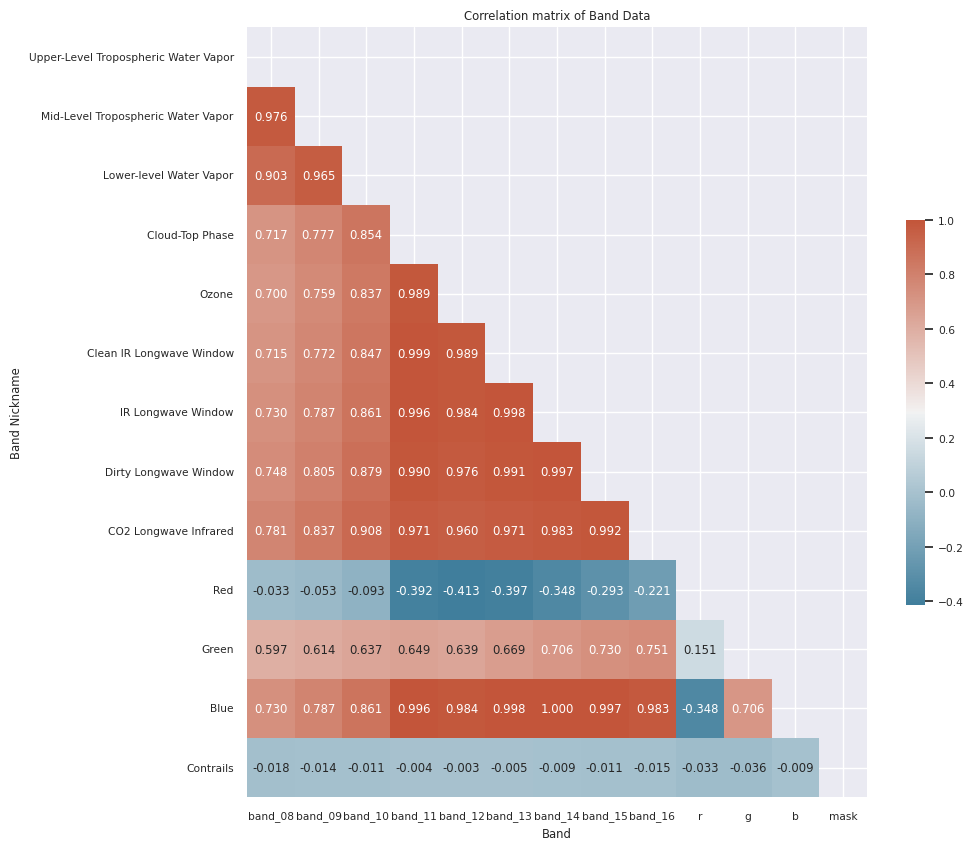

In [9]:
band_labels = ["band_08", "band_09", "band_10", "band_11", "band_12", "band_13", "band_14", "band_15", "band_16", "r", "g", "b", "mask"]
band_labels_nickname = ["Upper-Level Tropospheric Water Vapor", 
                       "Mid-Level Tropospheric Water Vapor", 
                       "Lower-level Water Vapor", 
                       "Cloud-Top Phase", 
                       "Ozone", 
                       "Clean IR Longwave Window", 
                       "IR Longwave Window", 
                       "Dirty Longwave Window", 
                       "CO2 Longwave Infrared",
                       "Red", "Green", "Blue",
                       "Contrails"]
plot_correlation_matrix(correlation_matrix, band_labels, band_labels_nickname)

Based on the correlation matrix, the optimal bands for contrail detection would likely be those that are less correlated with each other, as they provide unique information. The **Ash** false color image, which has a high correlation with contrails and is not highly correlated with any other bands, could be a good basis for contrail detection. Adding **bands 11 to 16** to this base might not be beneficial as their information is almost completely contained in the blue band already. However, adding **band08** as a fourth input channel could be useful as it is less correlated with the Ash colors and well correlated with the contrails, meaning it could add new and useful information. It's recommended not to add all three bands (08, 09, and 10) as they are highly correlated with each other.

> **Optimal Band**

In [10]:
def read_record(record_id, directory, mode):
    record_data = {}
    read = ["band_08", "band_11", "band_14", "band_15"]
    if mode == 'train':
        read.append('human_individual_masks')
    elif mode == 'val':
        read.append('human_pixel_masks')
    for x in read:
        if x == 'human_individual_masks':
            individual = np.load(os.path.join(directory, record_id, x + ".npy"))
            record_data['human_pixel_masks'] = individual.sum(axis=3) / individual.shape[3]
        else:
            record_data[x] = np.load(os.path.join(directory, record_id, x + ".npy"))
    return record_data

In [11]:
def normalize_range(data, bounds):
    return (data - bounds[0]) / (bounds[1] - bounds[0])

def get_ash_img(band08, band11, band14, band15):
    _T11_BOUNDS = (243, 303)
    _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
    _TDIFF_BOUNDS = (-4, 2)
    N_TIMES_BEFORE = 4

    r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(band14, _T11_BOUNDS)
    n = (band08 - 230) / 20
    
    false_color = np.clip(np.stack([r, g, b, n], axis=2), 0, 1)

    #false_color = np.stack([r, g, b, n], axis=2)
    #img = false_color[..., N_TIMES_BEFORE]
    #print(img.shape, img.mean(axis=(0,1)), img.min(axis=(0,1)), img.max(axis=(0,1)))
    
    return false_color

# 3️⃣ Transform

In [12]:
train_transform = Compose([ToTensor()])
val_transform = Compose([ToTensor()])
test_transform = Compose([ToTensor()])

The code above applies a transformation to the training, validation, and testing datasets. The transformation being applied here is `ToTensor()`, which is a common transformation in PyTorch that converts raw data into PyTorch tensors.

In detail:
- `train_transform = Compose([ToTensor()])`: This line applies the `ToTensor()` transformation to the training dataset. This converts the training data into PyTorch tensors.
- `val_transform = Compose([ToTensor()])`: Similarly, this line applies the same transformation to the validation dataset.
- `test_transform = Compose([ToTensor()])`: This line applies the `ToTensor()` transformation to the test dataset.

Tensors are multi-dimensional arrays with a uniform type (i.e., integer, float, etc.). PyTorch tensors are similar to NumPy’s ndarrays, with the addition being that Tensors can also be used on a GPU to accelerate computing. Converting your data into tensors is a necessary step before feeding it into your model for training or inference. The `Compose()` function allows for multiple transformations to be chained together. In this case, only one transformation (`ToTensor()`) is being applied, but more could be added if needed.

# 4️⃣ Dataset

In [13]:
data_dir: str = '/kaggle/input/google-research-identify-contrails-reduce-global-warming'
    
def get_band_images(idx: str, parrent_folder: str, band: str) -> np.array:
    return np.load(os.path.join(data_dir, parrent_folder, idx, f'band_{band}.npy'))


def get_ash_values(record_dir, allchannels):

    # get the bands of the record
    bands_data = []
        
    bands_data.append(np.load(os.path.join(record_dir, f'band_08.npy')))
    bands_data.append(np.load(os.path.join(record_dir, f'band_11.npy')))
    bands_data.append(np.load(os.path.join(record_dir, f'band_14.npy')))
    bands_data.append(np.load(os.path.join(record_dir, f'band_15.npy')))
        
    if allchannels: 
        images = get_ash_img(bands_data[0], bands_data[1], bands_data[2], bands_data[3])
        ash = torch.tensor(np.reshape(images, (256, 256, 24))).to(torch.float32).permute(2, 0, 1)

    else:
        # Stack band data along the channel axis
        bands_data = np.stack(bands_data, axis=-1)
        
        #This is used to test the 3 channels data
        band08 = bands_data[:,:,4,0]
        band11 = bands_data[:,:,4,2]
        band14 = bands_data[:,:,4,1]
        band15 = bands_data[:,:,4,3]
    
        #This is used to test the 9 channels data
        #band11 = np.stack([bands_data[:,:,5,0], bands_data[:,:,4,0], bands_data[:,:,6,0]], axis=-1)
        #band14 = np.stack([bands_data[:,:,5,1], bands_data[:,:,4,1], bands_data[:,:,6,1]], axis=-1)
        #band15 = np.stack([bands_data[:,:,5,2], bands_data[:,:,4,2], bands_data[:,:,6,2]], axis=-1)
        
        # get the false colour
        ash = get_ash_img(band08, band11, band14, band15)
        #ash = torch.tensor(np.reshape(ash, (256, 256, 9))).to(torch.float32).permute(2, 0, 1)
        
    return ash

class contrailsDataset(Dataset):
    def __init__(self,base_dir:str, mode:str, num_samples:int, transform, allchannels):
        super().__init__()
        
        # init the attributes
        self.base_dir:str = base_dir
        self.mode:str = mode
        self.transform = transform
        self.records:list[str] = os.listdir(self.base_dir + self.mode)
        self.allchannels = allchannels
        
        # get in-ordered samples in the population
        self.records = self.records[:num_samples]
        
    def get_ash_img(self, bands):
        band08 = bands[:,:,4,0]
        band11 = bands[:,:,4,2]
        band14 = bands[:,:,4,1]
        band15 = bands[:,:,4,3]
        return get_ash_img(band08,band11,band14,band15)

    def __getitem__(self, idx):
        record_id = self.records[idx]
        record_dir = os.path.join(self.base_dir,self.mode,record_id)
        
        ash = get_ash_values(record_dir, self.allchannels)
        
        pixel_masks = None        
         # If the data type is 'train' or 'validation', load the masks
        if self.mode in ['train', 'validation']:
            pixel_masks_file = os.path.join(record_dir, 'human_pixel_masks.npy')
            pixel_masks = np.load(pixel_masks_file)
            
            
        if self.allchannels == False:
            ash = self.transform(ash)
            
        if self.mode != 'test':
            pixel_masks = self.transform(pixel_masks)
            sample = {'mask': pixel_masks, 'ash': ash}
        else:
            sample = {'ash': ash}
        return sample

    def __len__(self):
        return len(self.records)

In [14]:
trainData = contrailsDataset(CONFIG['DATA_ROOT'], mode='train',num_samples=CONFIG['NUM_TRAIN_SAMPLES'], transform=train_transform, allchannels=True)
valData = contrailsDataset(CONFIG['DATA_ROOT'], mode='validation',num_samples=CONFIG['NUM_VAL_SAMPLES'], transform=val_transform, allchannels=True)
testData = contrailsDataset(CONFIG['DATA_ROOT'], mode='test', num_samples=CONFIG['NUM_TEST_SAMPLES'],transform=test_transform, allchannels=True)

# allchannels binary value is True when we want to test 24 channels input, and false we want to have 3 channels input
# This takes in 3 channels
trainData2 = contrailsDataset(CONFIG['DATA_ROOT'], mode='train',num_samples=CONFIG['NUM_TRAIN_SAMPLES'], transform=train_transform, allchannels=False)
valData2 = contrailsDataset(CONFIG['DATA_ROOT'], mode='validation',num_samples=CONFIG['NUM_VAL_SAMPLES'], transform=val_transform, allchannels=False)
testData2 = contrailsDataset(CONFIG['DATA_ROOT'], mode='test', num_samples=CONFIG['NUM_TEST_SAMPLES'],transform=test_transform, allchannels=False)

In [15]:
len(trainData), len(valData), len(testData)

(1000, 300, 2)

# 5️⃣ Data Loader

In [16]:
train_dataloader = DataLoader(trainData, 
                              batch_size=CONFIG['BATCH_SIZE'], 
                              shuffle=True)

val_dataloader = DataLoader(valData, 
                            batch_size=CONFIG['BATCH_SIZE'],
                            shuffle=True)

test_dataloader = DataLoader(testData, 
                             batch_size=CONFIG['BATCH_SIZE'], 
                             shuffle=False)

train_dataloader2 = DataLoader(trainData2, 
                              batch_size=16, 
                              shuffle=True)

val_dataloader2 = DataLoader(valData2, 
                            batch_size=16,
                            shuffle=True)

test_dataloader2 = DataLoader(testData2, 
                             batch_size=CONFIG['BATCH_SIZE'], 
                             shuffle=False)

# 6️⃣ EDA

In [17]:
def data_explotary(all_data_loader, type_data):
    contrail_image = 0
    no_contrail_image = 0


    for idx, batch in enumerate(all_data_loader): 
        mask = batch['mask']
        mask = torch.moveaxis(mask,1,-1)

        positive_count = 0
        negative_count = 0
        mask2 = mask[0].detach().numpy() 

        for row in range(256):
            for col in range(256):
                
                pixel_value = mask2[row, col]
                if pixel_value == 1:
                    positive_count += 1
                else:
                    negative_count += 1

        if positive_count > 0:
            contrail_image += 1
        else:
            no_contrail_image += 1
        

    print("Number of dataset:", len(all_train_data))
    print("Number of contrail images:", contrail_image)
    print("Number of no contrail images:", no_contrail_image)

    # Data for the pie chart
    data = [contrail_image, no_contrail_image]
    labels = ['Contrails Images', 'No Contrails Images']

    # Create a pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(f"Distribution of Contrails and Non-Contrails Images in the {type_data} Data")
    plt.show()

Number of dataset: 1000
Number of contrail images: 458
Number of no contrail images: 542


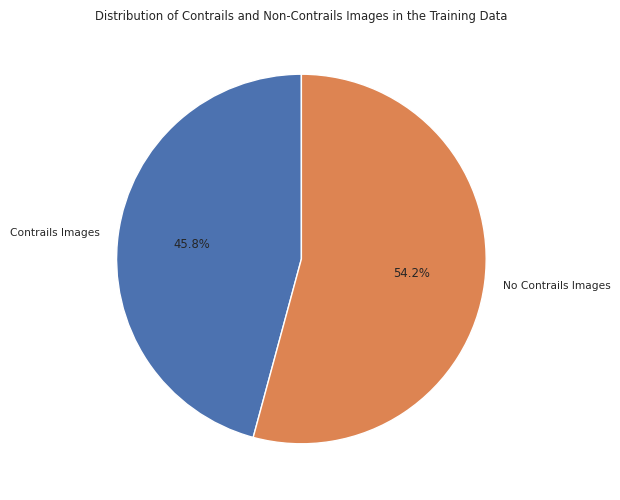

Number of dataset: 1000
Number of contrail images: 87
Number of no contrail images: 213


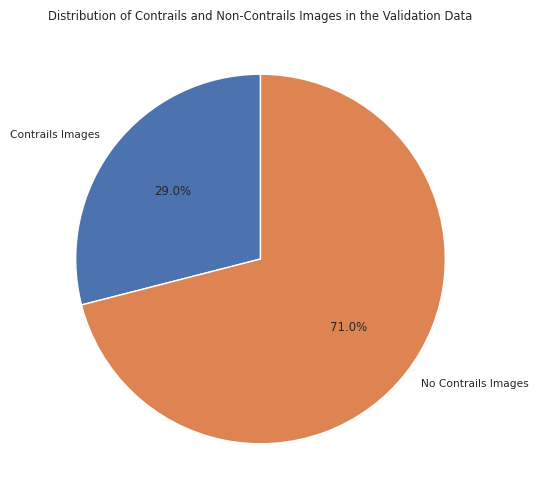

In [18]:
all_train_data = contrailsDataset(CONFIG['DATA_ROOT'], mode='train',num_samples=1000, transform=train_transform, allchannels=False)
all_train_data_loader = DataLoader(all_train_data, batch_size=1, shuffle=False)

all_validation_data = contrailsDataset(CONFIG['DATA_ROOT'], mode='validation',num_samples=300, transform=train_transform, allchannels=False)
all_validation_data_loader = DataLoader(all_validation_data, batch_size=1, shuffle=False)



# Visualise the composition of contrails dataset in both (1000) training and (300) validation datasets
# Training
data_explotary(all_train_data_loader, 'Training')
#Validation
data_explotary(all_validation_data_loader, 'Validation')


# 7️⃣ Models Loading and Setup

In [27]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'

ACTIVATION = 'sigmoid' # could be None for logits 

# create segmentation model with pretrained encoder

deeplabv3 = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    in_channels=4,
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
).to(device)


pspnet = smp.PSPNet(
    encoder_name='mit_b3', 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
).to(device)

pspnet2 = smp.PSPNet(
    encoder_name=ENCODER, 
    in_channels=4,
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
).to(device)

# This is used to test the performances between the 24 transformed to 3 channels approach and other approaches 
pspnet = smp.PSPNet(
    encoder_name=ENCODER, 
    in_channels=4,
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
).to(device)

unet = smp.Unet(
    encoder_name=ENCODER,
    in_channels=4,
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
).to(device)

# 8️⃣ Training

In [28]:
# Channel Reduction

class ChanneReduction(nn.Module):
    def __init__(self, num_classes=1):
        super(ChanneReduction, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=24, out_channels=30, kernel_size=(1,1))
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=20, kernel_size=(1,1))
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1,1))
        self.conv4 = nn.Conv2d(in_channels=10, out_channels=3, kernel_size=(1,1))
        
    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.conv2(x1)
        x1 = self.conv3(x1)
        x1 = self.conv4(x1)
    
        return x1


In [29]:
f_e = ChanneReduction()


class ProcessedDataDataset(torch.utils.data.Dataset):
    def __init__(self, data_loader, f_e_model, transform):
        super().__init__()
        self.data_loader = data_loader
        self.f_e_model = f_e_model
        self.transform = transform
    def __len__(self):
        return len(self.data_loader)

    def __getitem__(self, idx):
        batch = self.data_loader.dataset[idx]
        mask, ash = batch['mask'], batch['ash']
        
        ash = self.f_e_model(ash)
        
        sample = {'mask': mask, 'ash': ash}
        return sample


# This is used to transform 24 channels data to 3 channels data by applying the Channel Reduction function     
    
# Training Set
new_dataset = ProcessedDataDataset(train_dataloader, f_e, train_transform)
new_data_loader = DataLoader(new_dataset, batch_size=16, shuffle=True)

# Validation Set
new_dataset2 = ProcessedDataDataset(val_dataloader, f_e, train_transform)
new_data_loader2 = DataLoader(new_dataset2, batch_size=16, shuffle=False)

# 9️⃣ Visualization

In [30]:
def images_visualisation(batch): 
    mask, image = batch['mask'], batch['ash']

    image = torch.moveaxis(image,1,-1)
    mask = torch.moveaxis(mask,1,-1)

    for i in range(1):
    
        rgb_img = image[i].detach().numpy()
        rgb_mask = mask[i].detach().numpy()

        plt.figure(figsize=(18, 6))
    
        ax = plt.subplot(1, 3, 1)
        ax.imshow(rgb_img)
        ax.set_title('False color image')
    

        ax = plt.subplot(1, 3, 2)
        ax.imshow(rgb_mask, interpolation='none')
        ax.set_title('Ground truth contrail mask')
        
        ax = plt.subplot(1, 3, 3)
        ax.imshow(rgb_img)
        ax.imshow(rgb_mask, alpha=.4, interpolation='none')
        ax.set_title('Contrail mask on false color image');


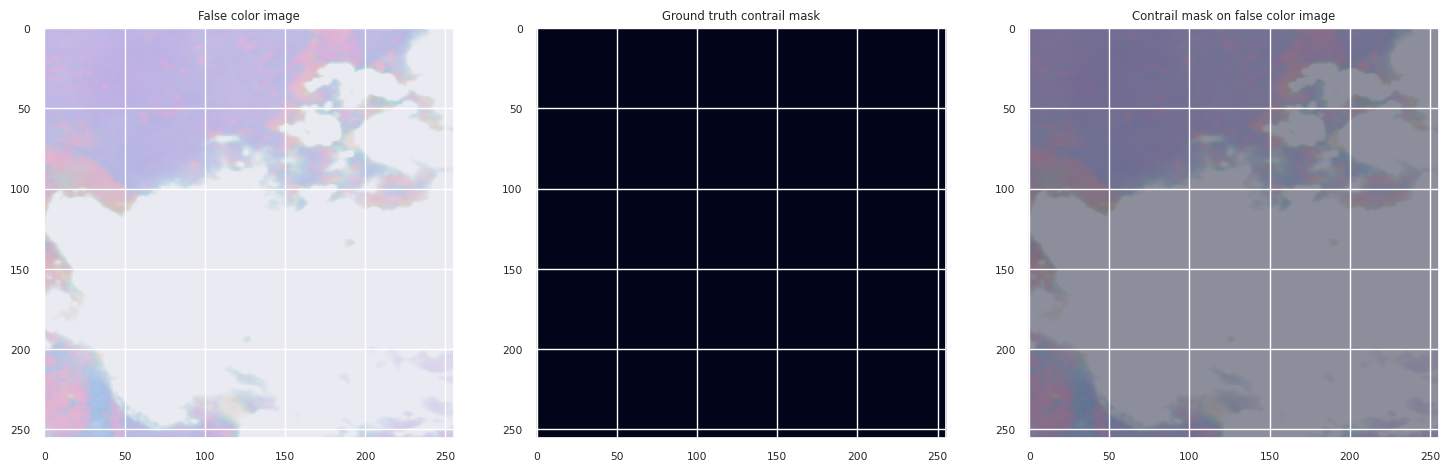

In [31]:
# Comparision between two different datasets

# This is from the transformed 24-channels-3-channels dataset
#batch = next(iter(new_data_loader))
#images_visualisation(batch)

# This is from the 3 channels dataset
batch = next(iter(train_dataloader2))
images_visualisation(batch)

In [32]:
def data_visualisation(train):
    
    plt.figure(figsize=(18,6))
    ax = plt.subplot(1, 3, 1)
    df_data = pd.DataFrame({'Loss': train.epoch_losses})
    sns.lineplot(data=df_data)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Model Average Training Loss over Epochs')

    ax = plt.subplot(1, 3, 2)
    df_data = pd.DataFrame({'Batch Losses': train.batch_losses})
    sns.lineplot(data=df_data)
    ax.set_xlabel('Batch')
    ax.set_ylabel('Loss')
    ax.set_title('Batch Loss')
    
    ax = plt.subplot(1, 3, 3)
    df_data = pd.DataFrame({'Loss': train.validation_loss})
    sns.lineplot(data=df_data)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Model Validation Loss over Epochs')
    
    plt.show()

In [33]:
train_iou_list = []
valid_iou_list = []
valid_iou_sum = 0

# This code initialises, trains and validates model
class training:
    
    def __init__(self, model, optimizer, loss_fn):
        self.validation_loss = []
        self.batch_losses = []
        self.epoch_losses = []
        self.learning_rates = []
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
    
    
    train_iou_list, valid_iou_list = [], []
    
    def fit(self, new_data_loader, new_data_loader2, is_implemented, is_fcn):
        for epoch in range(10):
            
            # Perform training & validation steps
            print('\nEpoch: {}'.format(epoch+1))
            
            print("New learning rate: {}".format(self.optimizer.param_groups[0]['lr']))
            self.learning_rates.append(self.optimizer.param_groups[0]['lr'])
        
             # Stores data about the batch
            batch_losses = []
            sub_batch_losses = []
            
            self.model.train()
            # Training loop
            train_iou, train_loss = 0., 0.
        
            for idx, batch in enumerate(new_data_loader): 
            
                mask, ash = batch['mask'], batch['ash']
                ash = ash.to(device)                
                self.optimizer.zero_grad()
                
                # forward
                out = self.model(ash)
                
                if is_fcn:
                    target_size = (240, 240)
                    mask = mask.float()
                    mask = F.interpolate(mask, size=target_size, mode='bilinear', align_corners=True)
                
                # loss
                if is_implemented:
                    mask = mask.float()
                    mask = mask.cuda()

                    loss = self.loss_fn(out, mask)
 
                else:
                    loss = self.loss_fn(out, mask_oh)
            
                # backpropagate gradients
                loss.backward()
            
                # optimizer step
                optimizer.step()         

                train_loss += loss.detach().cpu().numpy()
            
                # Saves data
                self.batch_losses.append(loss.item())
                batch_losses.append(loss)
                sub_batch_losses.append(loss)
            
                train_iou_list.append(1. * train_iou / len(train_dataloader))
            
            # Reports on the path
            mean_epoch_loss = torch.Tensor(batch_losses).mean()
            self.epoch_losses.append(mean_epoch_loss.item())
            print('Train Epoch: {} Average Loss: {:.6f}'.format(idx, mean_epoch_loss))
            
            n_train_batches = len(train_dataloader)
            train_iou_list.append(1. * train_iou / n_train_batches)
        
            print("\nValidating")
    
            # Validation loop
            self.model.eval()
            with torch.inference_mode():
                valid = []
                valid_iou, valid_loss = 0., 0.
                valid_iou_sum, valid_loss_sum = 0., 0.
                for idx, batch in enumerate(new_data_loader2):
                    mask2, ash2 = batch['mask'], batch['ash']
                
                    ash2 = ash2.to(device)
                    out2 = self.model(ash2)
                    
                    if is_fcn:
                        target_size = (240, 240)
                        mask2 = mask2.float()
                        mask2 = F.interpolate(mask2, size=target_size, mode='bilinear', align_corners=True)
                    
                    # loss
                    if is_implemented:
                        mask2 = mask2.float()
                        mask2 = mask2.cuda()
                                                             
                        loss_val = self.loss_fn(out2, mask2)
                    else:
                        loss_val = self.loss_fn(out2, mask_oh2)

                    valid_loss += loss_val
                    valid.append(loss_val.item())
            
                n_val_batches = len(val_dataloader)
    
                #valid_iou_list.append(1. * valid_iou / n_val_batches)
                valid_iou_list.append(valid_iou_sum)
            
                avg_loss = torch.Tensor(valid).mean().item()
                print('Train Epoch: {} Average Loss: {:.6f}'.format(idx, avg_loss))
                self.validation_loss.append(avg_loss)
                
        

In [34]:
# define loss function
dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=False)

# define optimizer
optimizer = torch.optim.SGD([ 
    dict(params=deeplabv3.parameters(), lr=0.001),
])

print('This is DeepLabV3')

train = training(deeplabv3, optimizer, dice_loss)
train.fit(train_dataloader2, val_dataloader2, True, False)
data_visualisation(train)


This is DeepLabV3

Epoch: 1
New learning rate: 0.001


AssertionError: Torch not compiled with CUDA enabled

In [ ]:


# define loss function
dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=False)

# define optimizer
optimizer = torch.optim.SGD([ 
    dict(params=pspnet2.parameters(), lr=0.001),
])

print('This is PSPNET')


train = training(pspnet2, optimizer, dice_loss)
train.fit(train_dataloader2, val_dataloader2, True, False)

data_visualisation(train)

In [ ]:
print('This is a UNET')

unet = unet.to('cuda')
dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=False)


criterion = nn.BCEWithLogitsLoss()


# define optimizer
optimizer = torch.optim.SGD([ 
    dict(params=unet.parameters(), lr=0.001),
])

train = training(unet, optimizer, criterion)
train.fit(train_dataloader2, val_dataloader2, True, False)
data_visualisation(train)

